<a href="https://colab.research.google.com/github/darksilvis/ZatureTespiti/blob/main/ZatureTespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

os.chdir(r"/content/görüntü işleme veri seti/chest_xray")

gorsel_boyutu = (224, 224)

def preprocess_with_clahe_and_gaussian(img):
    img_uint8 = (img * 255).astype(np.uint8)

    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    processed_channels = []
    for i in range(3):
        processed_channel = clahe.apply(img_bgr[:,:,i])
        processed_channels.append(processed_channel)

    img_clahe = cv2.merge(processed_channels)

    img_clahe = cv2.GaussianBlur(img_clahe, (3, 3), sigmaX=0.5)

    img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)

    img_processed = tf.keras.applications.mobilenet_v2.preprocess_input(img_rgb.astype(np.float32))
    return img_processed

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def flow_from_directory(self, *args, **kwargs):
        gen = super().flow_from_directory(*args, **kwargs)
        original_get_batches = gen._get_batches_of_transformed_samples

        def custom_get_batches(index_array):
            images, labels = original_get_batches(index_array)
            images = images.astype(np.float32) / 255.0 if images.max() > 1.0 else images.astype(np.float32)

            processed_images = np.array([preprocess_with_clahe_and_gaussian(img) for img in images])
            return processed_images, labels

        gen._get_batches_of_transformed_samples = custom_get_batches
        return gen

train_dir = "train"
val_dir = "val"
test_dir = "test"

train_datagen = CustomImageDataGenerator(rotation_range=15, zoom_range=0.1, horizontal_flip=True)
val_test_datagen = CustomImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=gorsel_boyutu,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=gorsel_boyutu,
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=gorsel_boyutu,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total_samples = normal_count + pneumonia_count

weight_for_normal = total_samples / (2 * normal_count)
weight_for_pneumonia = total_samples / (2 * pneumonia_count)

class_weight_dict = {0: weight_for_normal, 1: weight_for_pneumonia}

print("Class Weights:", class_weight_dict)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

test_generator.reset()
preds = model.predict(test_generator)
preds_binary = (preds > 0.5).astype(int)

print(classification_report(test_generator.classes, preds_binary, target_names=["Normal", "Pneumonia"]))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 729ms/step - accuracy: 0.7051 - loss: 0.5548 - val_accuracy: 0.8125 - val_loss: 0.4304
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 690ms/step - accuracy: 0.9033 - loss: 0.2381 - val_accuracy: 0.8125 - val_loss: 0.3816
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 705ms/step - accuracy: 0.9293 - loss: 0.1745 - val_accuracy: 0.7500 - val_loss: 0.4675
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 688ms/step - accuracy: 0.9359 - loss: 0.1655 - val_accuracy: 0.7500 - val_loss: 0.5052
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 689ms/step - accuracy: 0.9396 - loss: 0.1620 - val_accuracy: 0.8125 - val_loss: 0.3933
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 710ms/step - accuracy: 0.9404 - loss: 0.1583 - val_accuracy: 0.8750 - val_loss: 0.3521
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy: 0.9378 - loss: 0.1538 - val_accuracy: 0.8125 - val_loss: 0.3328
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 708ms/step - accuracy: 0.9399 -

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1) Tek resimle tahmin yapma fonksiyonu
def predict_single_image(model, image_path):
    # Resmi oku (OpenCV BGR, dönüştür RGB)
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Boyutlandır (modeldeki girdi boyutuna göre)
    img_resized = cv2.resize(img_rgb, gorsel_boyutu)

    # Model inputuna uygun hale getirmek için float ve 0-1 normalizasyon
    img_norm = img_resized.astype(np.float32) / 255.0

    # Ön işleme uygula
    img_preprocessed = preprocess_with_clahe_and_gaussian(img_norm)

    # Batch boyutu ekle
    input_tensor = np.expand_dims(img_preprocessed, axis=0)

    # Tahmin
    pred = model.predict(input_tensor)[0][0]
    label = 'Pneumonia' if pred > 0.5 else 'Normal'

    # Sonucu göster
    plt.imshow(img_resized)
    plt.title(f"Tahmin: {label} ({pred:.2f})")
    plt.axis('off')
    plt.show()

    return label, pred

# -----------------------------------------------------------
# 2) Orijinal ve ön işlemeli resmi yan yana gösterme fonksiyonu
def show_preprocessing_effect(image_path):
    # Resmi oku
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Boyutlandır
    img_resized = cv2.resize(img_rgb, gorsel_boyutu)

    # Normalize et
    img_norm = img_resized.astype(np.float32) / 255.0

    # Ön işleme uygula
    img_preprocessed = preprocess_with_clahe_and_gaussian(img_norm)

    # Görüntüle
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_resized)
    axs[0].set_title("Orijinal Resim")
    axs[0].axis('off')

    axs[1].imshow(((img_preprocessed + 1) * 127.5).astype(np.uint8))  # MobileNetV2 preprocess_input çıktı aralığı [-1,1] olabilir, görsel için uygun aralığa getir
    axs[1].set_title("Ön İşlem Uygulanmış")
    axs[1].axis('off')

    plt.show()

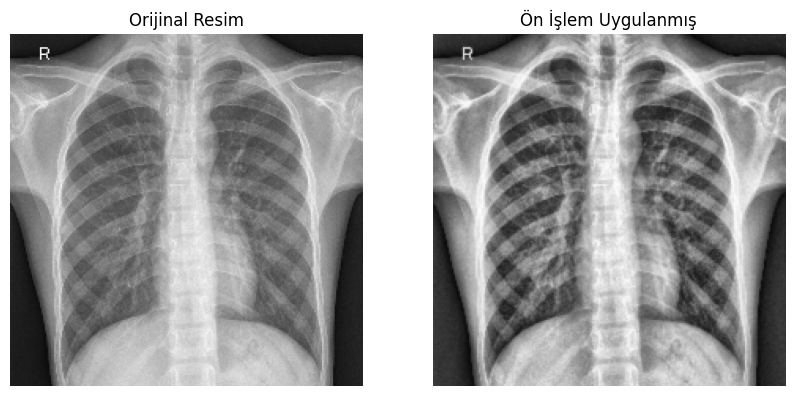

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


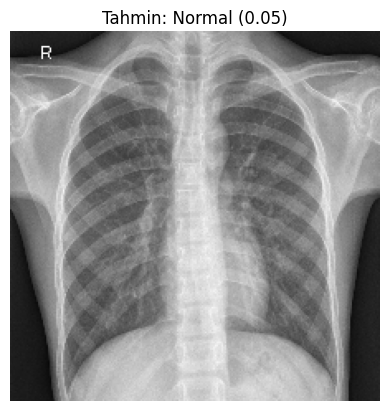

('Normal', np.float32(0.046200547))

In [ ]:
# NORMAL RESIM DENEME

image_path = "/content/görüntü işleme veri seti/chest_xray/test/NORMAL/IM-0005-0001.jpeg"

# Ön işlemenin etkisini gör
show_preprocessing_effect(image_path)

# Tek resimle tahmin yap
predict_single_image(model, image_path)

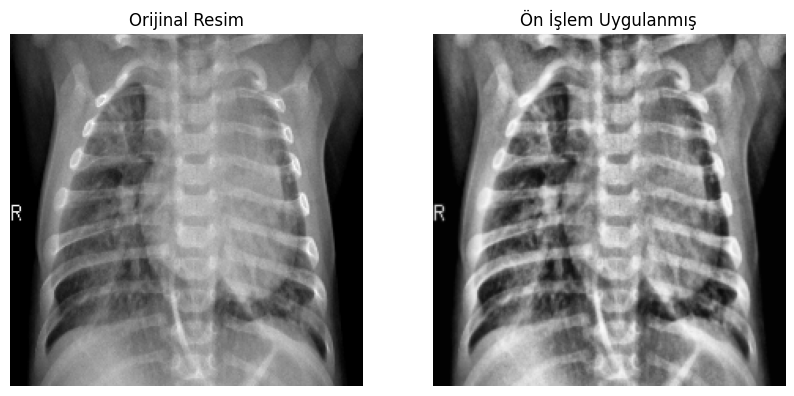

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


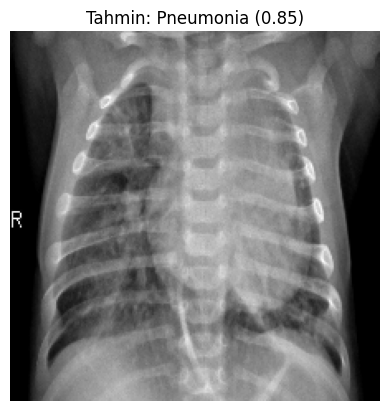

('Pneumonia', np.float32(0.84523696))

In [ ]:
# ZATURRE RESIM DENEME

image_path = "/content/görüntü işleme veri seti/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"

# Ön işlemenin etkisini gör
show_preprocessing_effect(image_path)

# Tek resimle tahmin yap
predict_single_image(model, image_path)

In [ ]:
# NORMAL RESIM DENEME

image_path = "/content/görüntü işleme veri seti/chest_xray/test/NORMAL/IM-0003-0001.jpeg"

# Ön işlemenin etkisini gör
show_preprocessing_effect(image_path)

# Tek resimle tahmin yap
predict_single_image(model, image_path)

In [ ]:
# ZATURRE RESIM DENEME

image_path = "/content/görüntü işleme veri seti/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg"

# Ön işlemenin etkisini gör
show_preprocessing_effect(image_path)

# Tek resimle tahmin yap
predict_single_image(model, image_path)